# Normalization with ANT to the 1st level output(Applynorm function)

In [1]:
import os
from os.path import join as opj
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info

Failed to import duecredit due to No module named 'duecredit'
/home/zohyos7/anaconda3/lib/python3.6/site-packages/bids/grabbids/__init__.py:6: FutureWarning: grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8
  warnings.warn("grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8", FutureWarning)


In [2]:
#set dir
experiment_dir = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

# task name
task_list = ['tom']

# Smoothing withds used during normalization
fwhm = [4, 8]

# MNI template
template = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

In [3]:
#subject list
subject_list = os.listdir("/data/wellbeing_bids")
subject_list.remove('dataset_description.json')
subject_list = [sub[-4:] for sub in subject_list]

In [4]:
subject_list = ['2797']

In [5]:
# Apply Transformation Node
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=5,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])


In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name','fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj('/data/wellbeing_analysis/datasink/1stLevel', 'sub-{subject_id}', 'task-{task_name}', 
                        'fwhm-{fwhm_id}','???_00??.nii'),
             'transform': opj('/data/wellbeing_analysis/datasink/antsreg', 'sub-{subject_id}', 'transformComposite.h5')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_fwhm_id_%s_subject_id_%s_task_name_%s/'  % (f, sub, task),
                'sub-%s/con/task-%s/fwhm-%s/' % (sub, task, f))
               for f in fwhm
               for task in task_list
               for sub in subject_list]
subjFolders = [('_apply2con%s/' % (i), '') for i in range(5)]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [7]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('task_name', 'task_name'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                             ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'antsflow.@con')])
                  ])

181115-12:38:37,901 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/antsflow/graph.png (graph2use=colored, simple_form=True).


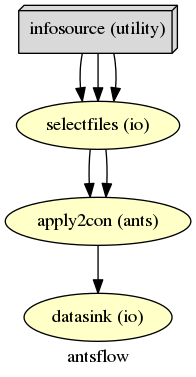

In [8]:
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)


from IPython.display import Image
Image(filename='/data/wellbeing_analysis/workingdir/antsflow/graph.png')

In [9]:
antsflow.run('MultiProc', plugin_args={'n_procs':5})

181115-12:38:40,418 nipype.workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging', 'monitoring']
181115-12:38:40,658 nipype.workflow INFO:
	 Running in parallel.
181115-12:38:40,664 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 5/5.
181115-12:38:40,749 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/data/wellbeing_analysis/workingdir/antsflow/_fwhm_id_8_subject_id_2797_task_name_tom/selectfiles".181115-12:38:40,750 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/data/wellbeing_analysis/workingdir/antsflow/_fwhm_id_4_subject_id_2797_task_name_tom/selectfiles".

181115-12:38:40,760 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181115-12:38:40,772 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181115-12:38:40,772 nipype.workflow INFO:
	 [Node] Finished "antsflow.s

## Compare before & after Apply_Norm

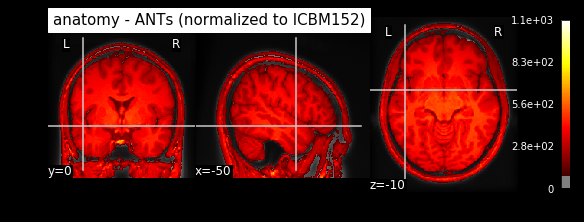

In [4]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
plot_stat_map(
    '/data/wellbeing_analysis/datasink/antsreg/sub-2528/transform_Warped.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz',
    threshold=100, display_mode='ortho', cut_coords=(-50, 0, -10))

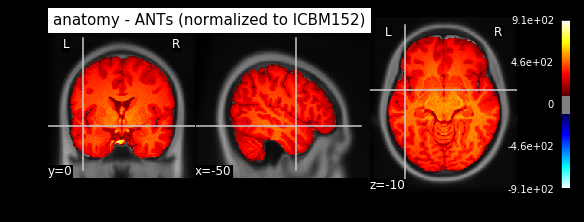

In [2]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
plot_stat_map(
    '/data/wellbeing_analysis/datasink/antsflow/sub-2528/anat/sub-2528_T1w_brain_trans.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz',
    threshold=100, display_mode='ortho', cut_coords=(-50, 0, -10))